In [43]:
import firedrake
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

# Grad-Shafranov FEM solver

This file presents a FEM solver for Grad-Shafranov as a boundary-value problem.
The function GradShafranov takes as input the function G and returns the solution of the problem.
The Mesh, the function space and the (x,y) coordinates must be defined before calling the function.

The default boundary conditions are Homogeneous Dirichlet. These are adopted unless the user specifies otherwise.
The default coordinates adopted are toroidal coordinates (R,z). The user can switch to Cartesian coordinates by specifying "Cartesian = True", but remark that the aspect ratio "eps" must be defined.

In [47]:
def GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.0, 'on_boundary')):

  # Define trial and test functions:
  psi = Function(V)
  phi = TestFunction(V)

  # Define the variational problem:
  if (Cartesian == False):
    L  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (G(x,psi) * phi) * dx # for toroidal coordinates
  else:
    L = dot(grad(psi), grad(phi))/(1 + eps*x) * dx - r0**2 / (1 + eps*x) * G(x,psi) * phi * dx # for Cartesian nondimensional coordinates

  # Solve with Newton's iterative method:
  solve(L == 0, psi, bcs=bc,
        solver_parameters={'snes_type': 'newtonls',
                          'snes_monitor': None,
                          'ksp_type': 'preonly',
                         'pc_type': 'lu'}
        );

  return psi

## Benchmarking with exact solutions:

Here, some exact solutions of Grad-Shafranov as a boundary value problem from literature are taken into account to test the solver.

### 1. Solov'ev equilibrium in toroidal coordinates:

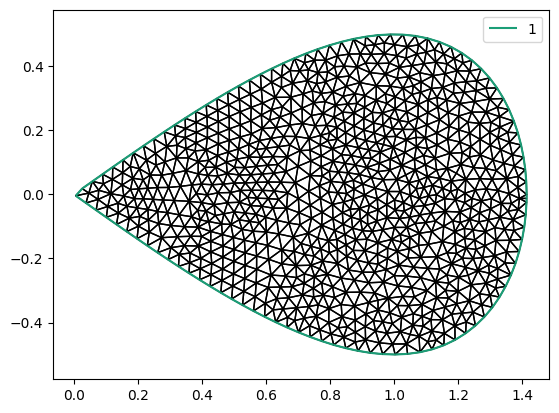

In [45]:
# Import Mesh:
mesh = Mesh(r"../Meshes/drop/drop_4.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

  0 SNES Function norm 6.122759904735e-02
  1 SNES Function norm 4.305505896881e-07
  2 SNES Function norm 9.651092553912e-11


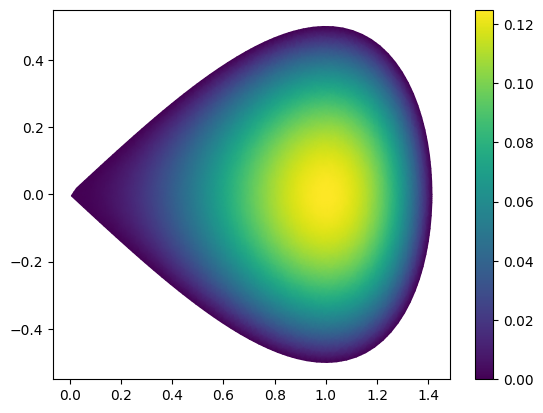

In [48]:
# Solov'ev equilibrium with G1 = 1, G2 = 1:
def G(x,psi):
  return x**2 + 1

# Numerical solution:
psi = GradShafranov(G)

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q)

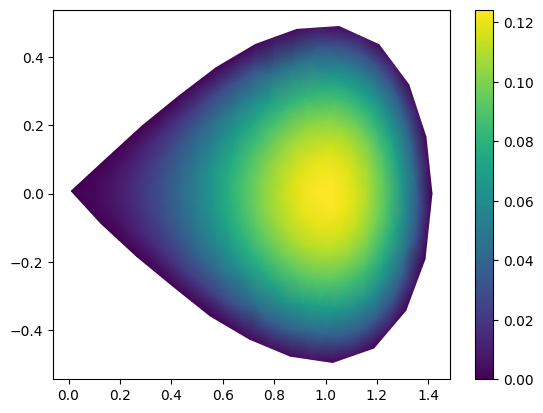

In [24]:
# Exact Solution (in toroidal coordinates):
psi_exact_fun = lambda x,y: ( 1 - (2*y)**2 - (2*(x-1) + (x-1)**2)**2 ) / 8
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q)

  0 SNES Function norm 2.205869980404e-01
  1 SNES Function norm 1.052298506065e-05
  2 SNES Function norm 3.136864232053e-09
  3 SNES Function norm 9.839323610355e-13
  0 SNES Function norm 1.931481912621e-01
  1 SNES Function norm 3.462952765623e-06
  2 SNES Function norm 5.156592746371e-10
  0 SNES Function norm 1.144250712106e-01
  1 SNES Function norm 1.206387570717e-06
  2 SNES Function norm 2.387868184163e-10
  0 SNES Function norm 6.122759904735e-02
  1 SNES Function norm 4.305505896881e-07
  2 SNES Function norm 9.651092553912e-11


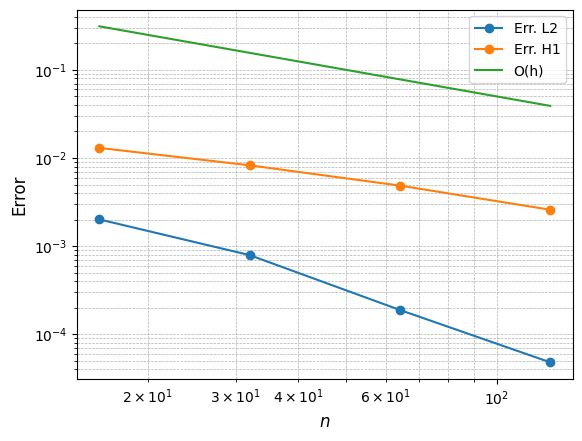

In [55]:
# Error convergence study:
mesh_files = np.array(("drop_1.msh", "drop_2.msh", "drop_3.msh", "drop_4.msh"))
n_vec = np.array((16,32,64,128))
err_L2 = np.zeros(n_vec.shape[0])
err_H1 = np.zeros(n_vec.shape[0])

for ii in range(n_vec.shape[0]):
  # Import Mesh:
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"../Meshes/drop/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  # Numerical solution:
  psi = GradShafranov(G, bc = DirichletBC(V, 0.0, 'on_boundary'))

  # Exact solution:
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  # Errors:
  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

# Plot L2/H1 error against n:
plt.loglog(n_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(n_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(n_vec, 5./n_vec, label='O(h)')
plt.xlabel(r'$n$', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

### 2. Solov'ev equilibrium in Cartesian coordinates:

In [56]:
# Define parameters for the D-shape:
R0 = 5/3          # major radius
r0 = 1/2          # minor radius
tau = 0           # triangularity
eps = r0 / R0     # aspect ratio
b = 1 - eps       # elongation

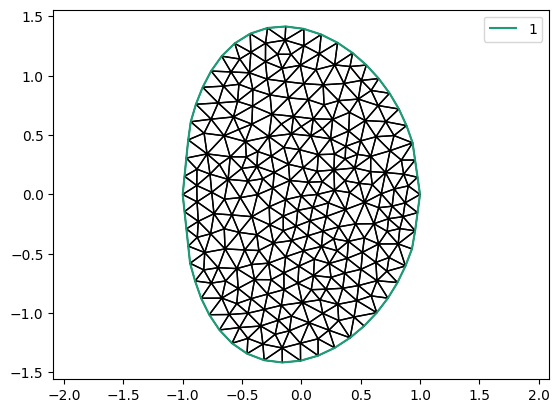

In [59]:
# Import Mesh:
mesh = Mesh(r"../Meshes/D_mesh/D_mesh_2.msh")

# The mesh above depends on the parameters defined --> for the moment they are defined as well with the same values in the .geo file.

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 1)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

  0 SNES Function norm 8.109104360541e-01
  1 SNES Function norm 1.148653455472e-04
  2 SNES Function norm 2.100218593750e-08
  3 SNES Function norm 3.888144875281e-12


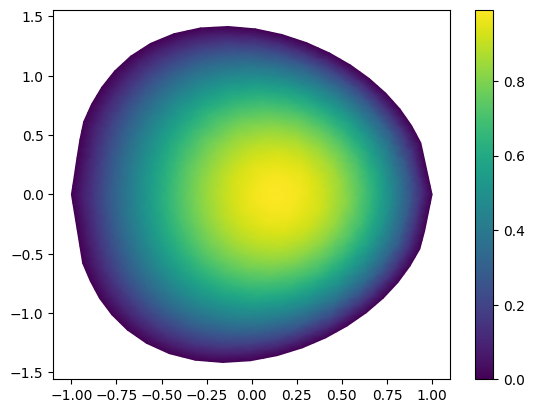

In [60]:
# G1(psi) = alpha = costant, G2(psi) = beta = constant:
alpha = ( 4*(r0**2+b**2)*eps + r0**2 * (2*tau - eps**3) ) / ( 2*R0**2 * eps * r0**2 * b**2)
beta = - tau / (eps * b**2)

# Define G1 and G2 as functions of cartesian coordinates
# Solver uses toroidal coordinates, the input variables
def G(x,psi):
  return alpha * (R0 * (1+eps*x))**2 + beta

# Numerical solution:
psi = GradShafranov(G, Cartesian = True, bc = DirichletBC(V, 0.0, 'on_boundary'))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q)

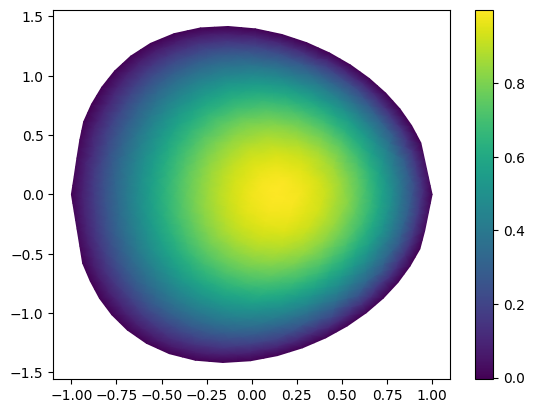

In [61]:
# Exact Solution (in cartesian coord):
psi_exact_fun = lambda x,y: 1-(x-eps/2*(1-x**2))**2-((1-eps**2/4)*(1+eps*x)**2+tau*x*(1+eps/2*x))*(r0/b*y)**2
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q)

  0 SNES Function norm 3.530688110499e-01
  1 SNES Function norm 1.319662854571e-05
  2 SNES Function norm 5.338839862306e-10
  0 SNES Function norm 8.109104360541e-01
  1 SNES Function norm 1.148653455472e-04
  2 SNES Function norm 2.100218593750e-08
  3 SNES Function norm 3.888144875281e-12
  0 SNES Function norm 4.336338524042e-01
  1 SNES Function norm 2.061337691795e-05
  2 SNES Function norm 1.202826317143e-09
  0 SNES Function norm 2.238483916300e-01
  1 SNES Function norm 4.669879329623e-06
  2 SNES Function norm 7.398638488968e-11


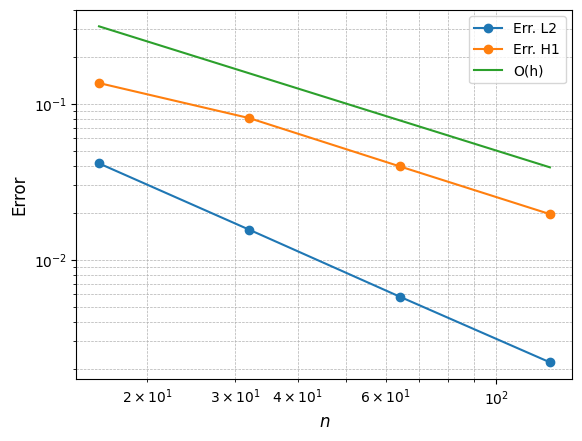

In [62]:
mesh_files = np.array(("D_mesh_1.msh", "D_mesh_2.msh", "D_mesh_3.msh", "D_mesh_4.msh"))
n_vec = np.array((16,32,64,128))
err_L2 = np.zeros(n_vec.shape[0])
err_H1 = np.zeros(n_vec.shape[0])

for ii in range(n_vec.shape[0]):
  # Import Mesh:
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"../Meshes/D_mesh/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 1)
  x,y = SpatialCoordinate(mesh)

  # Numerical solution:
  psi = GradShafranov(G, Cartesian = True, bc = DirichletBC(V, 0.0, 'on_boundary'))

  # Exact solution:
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  # Errors:
  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

# L2/H1 error against n:
plt.loglog(n_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(n_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(n_vec, 5./n_vec, label='O(h)')
plt.xlabel(r'$n$', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

### 3. Linear poloidal J on elliptic domain:

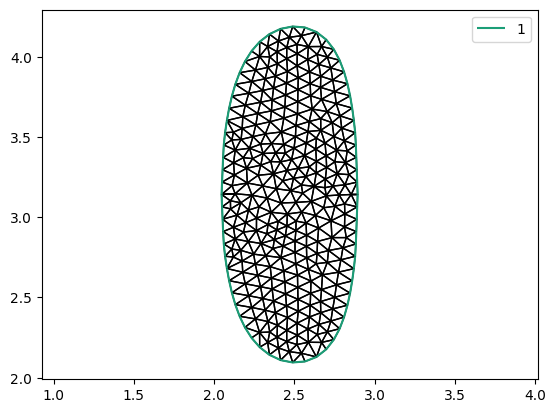

In [63]:
# Import Mesh:
mesh = Mesh(r"../Meshes/elliptic/elliptic_3.msh")

# Plot it
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()
ax.axis('equal')

# Define Function Space
V = FunctionSpace(mesh, 'P', 2)
x,y = SpatialCoordinate(mesh) # R = x, z = y.

Remark: the boundary conditions here are non-physical as the flux is lifted by "0.5". This is necessary as with homogeneous Dirichlet conditions the solution is the trivial one (psi=0 makes GS 0=0). The idea is to downlift back the numerical solution to enforce zero flux at the boundary. This is non-necessary here as this simulation is just needed to test the solver.

  0 SNES Function norm 9.166396878140e+00
  1 SNES Function norm 3.279095552989e-10


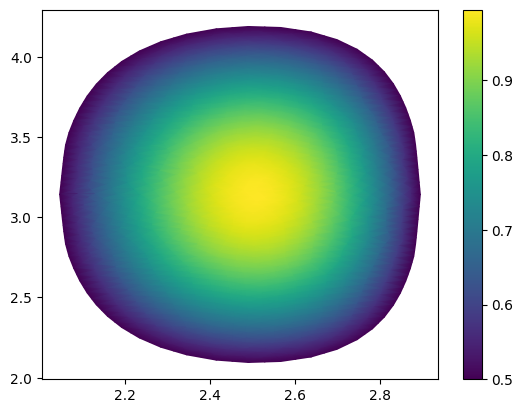

In [69]:
# G1 = psi, G2 = psi
def G(x,psi):
  return (x**2 + 1) * psi

# Numerical solution:
#psi = GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.0, 'on_boundary'))
psi = GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.5, 'on_boundary'))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi, axes=ax)
fig.colorbar(q)

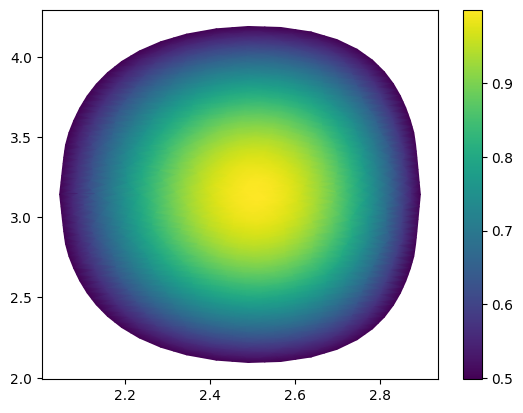

In [70]:
# Exact Solution:
psi_exact_fun = lambda x,y: cos(x**2 / 2)*cos(y) #- 0.5
psi_exact = Function(V)
psi_exact.interpolate(psi_exact_fun(x,y))

# Plot:
fig, ax = plt.subplots()
q = tripcolor(psi_exact, axes=ax)
fig.colorbar(q)

  0 SNES Function norm 5.449821246544e+00
  1 SNES Function norm 1.014454339134e-09
  0 SNES Function norm 6.726844015094e+00
  1 SNES Function norm 7.202502890336e-10
  0 SNES Function norm 9.166396878140e+00
  1 SNES Function norm 3.279095552989e-10
  0 SNES Function norm 1.260536716974e+01
  1 SNES Function norm 1.323329086332e-10


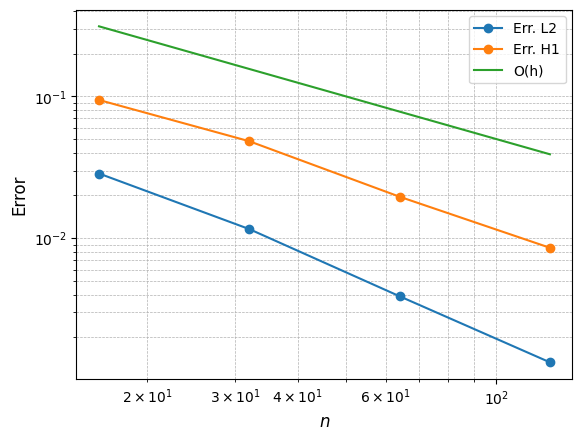

In [71]:
mesh_files = np.array(("elliptic_1.msh", "elliptic_2.msh", "elliptic_3.msh", "elliptic_4.msh"))
n_vec = np.array((16,32,64,128))
err_L2 = np.zeros(n_vec.shape[0])
err_H1 = np.zeros(n_vec.shape[0])

for ii in range(n_vec.shape[0]):
  mesh_name = mesh_files[ii]
  mesh = Mesh(r"../Meshes/elliptic/" + mesh_name)
  V = FunctionSpace(mesh, 'P', 2)
  x,y = SpatialCoordinate(mesh)

  psi = GradShafranov(G, Cartesian = False, bc = DirichletBC(V, 0.5, 'on_boundary'))
  psi_exact = Function(V)
  psi_exact.interpolate(psi_exact_fun(x,y))

  err_L2[ii] =  errornorm(psi_exact, psi, 'L2')
  err_H1[ii] = errornorm(psi_exact, psi, 'H1')

# L2/H1 error against n:
plt.loglog(n_vec, err_L2, marker='o', label='Err. L2')
plt.loglog(n_vec, err_H1, marker='o', label='Err. H1')
plt.loglog(n_vec, 5./n_vec, label='O(h)')
plt.xlabel(r'$n$', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)